In [1]:
import os
import pandas as pd

# Containts 0.0 values: 2024-12,
# Containts no 0.0 values: 2024-08,

folder_path = os.path.join(os.getcwd(), "data", "nordic", "2024-08")
csv_files = [file for file in os.listdir(folder_path) if file.endswith('csv')]

df_frequency_merged = pd.DataFrame()

for file in csv_files:
	file_path = os.path.join(folder_path, file)
	df_frequency = pd.read_csv(file_path, header=0, index_col=0, parse_dates=True)
	if len(df_frequency[df_frequency['Value'] < 40.0]) > 0:
		print(f"File {file} contains values below 40.0")
	# df_frequency['Value'] = df_frequency['Value'].astype(float)
	df_frequency_merged = pd.concat([df_frequency_merged, df_frequency])

# Sort the merged DataFrame by index
df_frequency_merged.sort_index(inplace=True)

# Subsample to have second instead of millisecond, not use mean
samples = [df_frequency_merged] + [df_frequency_merged.iloc[i::10] for i in range(10)]
# df_frequency_merged = df_frequency_merged.iloc[::10]

# Print the first few rows to verify the structure
print("\nStructure of merged_frequency_data:")
print(df_frequency_merged.head())
print("\nData types of merged_frequency_data:")
print("Time (index):", df_frequency_merged.index.dtype, "\nValue:", df_frequency_merged['Value'].dtype)




Structure of merged_frequency_data:
                            Value
Time                             
2024-08-01 00:00:00.000  50.00150
2024-08-01 00:00:00.100  50.00175
2024-08-01 00:00:00.200  50.00205
2024-08-01 00:00:00.300  49.99971
2024-08-01 00:00:00.400  49.99908

Data types of merged_frequency_data:
Time (index): datetime64[ns] 
Value: float64


In [2]:
df_below_40 = df_frequency_merged[df_frequency_merged["Value"] < 40.0]
print(len(df_below_40))
print(df_below_40.head())

0
Empty DataFrame
Columns: [Value]
Index: []


In [3]:
def calculate_and_print_percentage(df, lower_bound, upper_bound, description):
	percentage = (
		(df["Value"] > lower_bound) & (df["Value"] <= upper_bound)
    ).mean() * 100
	print(f"% of entries {description}: {percentage}%")

frequency_ranges = [
    (float("-inf"), 49.9, "below 49.9"),
    (50.1, float("inf"), "above 50.1"),
    (float("-inf"), 49.8, "below 49.8"),
    (50.2, float("inf"), "above 50.2"),
    (float("-inf"), 49.7, "below 49.7"),
    (50.3, float("inf"), "above 50.3"),
]

for lower_bound, upper_bound, description in frequency_ranges:
    calculate_and_print_percentage(
        df_frequency_merged, lower_bound, upper_bound, description
    )

mean_frequency = df_frequency_merged["Value"].mean()
std_dev_frequency = df_frequency_merged["Value"].std()
print(f"Number of entries: {len(df_frequency_merged)}")
print(f"Mean frequency: {mean_frequency}")
print(f"Standard Deviation of frequency: {std_dev_frequency}")
print(f"Minimum frequency: {df_frequency_merged['Value'].min()}")
print(f"Maximum frequency: {df_frequency_merged['Value'].max()}")

% of entries below 49.9: 1.0735021529239082%
% of entries above 50.1: 1.3075934829397993%
% of entries below 49.8: 0.0006237057405614928%
% of entries above 50.2: 0.023895025916840902%
% of entries below 49.7: 0.0%
% of entries above 50.3: 0.00016059489128230053%
Number of entries: 26775447
Mean frequency: 50.00020666779609
Standard Deviation of frequency: 0.04121646010583126
Minimum frequency: 49.79185
Maximum frequency: 50.34198


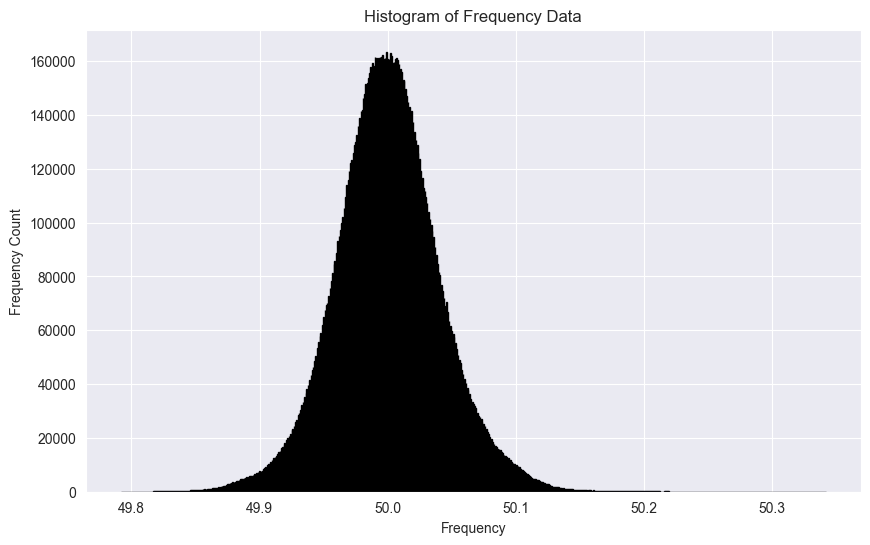

In [4]:
import matplotlib.pyplot as plt

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(
    df_frequency_merged["Value"],
    bins=1000,
    color="blue",
    edgecolor="black",
)
plt.title("Histogram of Frequency Data")
plt.xlabel("Frequency")
plt.ylabel("Frequency Count")
plt.grid(True)
plt.show()

In [5]:
# Make QQ-plot of df_frequency_merged["Value"]
#
# import scipy.stats as stats
# import matplotlib.pyplot as plt
#
# stats.probplot(df_frequency_merged["Value"], dist="norm", plot=plt)
# plt.title("Q-Q Plot: Frequency Data vs Normal Distribution")
# plt.show()



In [6]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
import os
from tqdm import tqdm  # Added tqdm for timing

x_th_list = [round(50.10 + i * 0.01, 2) for i in range(10)]
alpha_list = [round(0.05 + i * 0.05, 2) for i in range(40)]

dict_results = dict()
for subsample_idx, subsample in enumerate(samples):
    sub_key = str(subsample_idx)
    dict_results[sub_key] = {}

    for alpha in alpha_list:
        alpha_key = str(alpha)
        dict_results[sub_key][alpha_key] = {}

        for x_th in x_th_list:
            x_th_key = str(x_th)
            dict_results[sub_key][alpha_key][x_th_key] = {
                'directory_save': os.path.join(
                    os.getcwd(), 'results', 'nordic', 'right', '2D', 'unscaled'),
                'm_values': None,
                'beta_values': None,
                'average_beta': None,
                'likelihood_values': None,
                'converged': None
            }

# Loop with tqdm to track timing
for subsample_idx, df_frequency_merged_subsample in tqdm(enumerate(samples), total=len(samples), desc="Processing subsamples"):
    for x_th in x_th_list:
        for alpha in alpha_list:
            # Step 1: Select data points
            selected_data = df_frequency_merged_subsample[df_frequency_merged_subsample["Value"] >= x_th]

            # Step 2: Calculate differences with 50.00
            deltas = selected_data["Value"] - 50.00

            # Step 3: Order the deltas from large to small and index them
            ordered_deltas = 50.00 + deltas.sort_values(ascending=False).reset_index(drop=True)

            # Step 4-7:
            m_values = 1000
            beta_values = []
            likelihood_values = []
            converged_list = []

            if len(ordered_deltas) < m_values:
                print(f"Not enough data points for x_th={x_th} in subsample {subsample_idx}. Skipping.")
                break

            for k in range(10, m_values + 1):
                def neg_log_likelihood(beta):
                    if beta <= 0:
                        return np.inf  # Invalid beta values
                    term1 = k / beta
                    term2 = alpha * k * ordered_deltas[k] ** beta * np.log(ordered_deltas[k])
                    term3 = np.sum(np.log(ordered_deltas[:k]))
                    term4 = alpha * np.sum(ordered_deltas[:k] ** beta * np.log(ordered_deltas[:k]))
                    return term1 + term2 + term3 - term4

                result = opt.minimize(neg_log_likelihood, x0=[2.0], bounds=[(1e-6, None)], method='L-BFGS-B')

                if result.success:
                    beta_k = result.x[0]
                    log_likelihood_k = -result.fun  # Convert back to log-likelihood
                    beta_values.append(beta_k)
                    likelihood_values.append(log_likelihood_k)
                    converged_list.append(True)
                else:
                    beta_k = result.x[0]
                    log_likelihood_k = -result.fun
                    beta_values.append(beta_k)
                    likelihood_values.append(log_likelihood_k)
                    converged_list.append(False)
                    # print(f"Failed to converge for k={k}")

            # Step 7: Make Hill plot
            plt.plot(range(10, m_values + 1), beta_values, marker="o", markersize=0.5)
            plt.xlabel("k")
            plt.ylabel(r"$\beta_k$")
            plt.title(f"MLE-based Tail Shape Estimation Plot; alpha={alpha}")
            os.makedirs(dict_results[str(subsample_idx)][str(alpha)][str(x_th)]['directory_save'], exist_ok=True)
            plt.savefig(os.path.join(dict_results[str(subsample_idx)][str(alpha)][str(x_th)]['directory_save'], f"hill_plot_{str(subsample_idx)}_{str(x_th)}_{str(alpha)}.png"))
            plt.close()

            # Average beta (excluding first)
            average_beta = np.mean(beta_values[20:])

            # Save results
            dict_results[str(subsample_idx)][str(alpha)][str(x_th)]['m_values'] = m_values
            dict_results[str(subsample_idx)][str(alpha)][str(x_th)]['beta_values'] = beta_values
            dict_results[str(subsample_idx)][str(alpha)][str(x_th)]['average_beta'] = average_beta
            dict_results[str(subsample_idx)][str(alpha)][str(x_th)]['likelihood_values'] = likelihood_values
            dict_results[str(subsample_idx)][str(alpha)][str(x_th)]['converged_list'] = converged_list



Processing subsamples:   0%|          | 0/11 [00:00<?, ?it/s]/var/folders/yf/npsl41_n451c_8bd25kz9kwh0000gn/T/ipykernel_18687/1885901300.py:59: RuntimeWarning: overflow encountered in power
  term2 = alpha * k * ordered_deltas[k] ** beta * np.log(ordered_deltas[k])
/var/folders/yf/npsl41_n451c_8bd25kz9kwh0000gn/T/ipykernel_18687/1885901300.py:62: RuntimeWarning: invalid value encountered in subtract
  return term1 + term2 + term3 - term4
/var/folders/yf/npsl41_n451c_8bd25kz9kwh0000gn/T/ipykernel_18687/1885901300.py:59: RuntimeWarning: overflow encountered in multiply
  term2 = alpha * k * ordered_deltas[k] ** beta * np.log(ordered_deltas[k])
/Users/hendrik/Documents/TUe/Master/IAM/year 2/research topic/NEW/code/venv/lib/python3.11/site-packages/numpy/_core/_methods.py:52: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/hendrik/Documents/TUe/Master/IAM/year 2/research topic/NEW/code/venv/lib/python3.11/site-packages/s

Not enough data points for x_th=50.19 in subsample 1. Skipping.


Processing subsamples:  27%|██▋       | 3/11 [1:04:59<2:47:44, 1258.11s/it]

Not enough data points for x_th=50.19 in subsample 2. Skipping.


Processing subsamples:  36%|███▋      | 4/11 [1:23:57<2:21:14, 1210.69s/it]

Not enough data points for x_th=50.19 in subsample 3. Skipping.


Processing subsamples:  45%|████▌     | 5/11 [1:42:24<1:57:18, 1173.07s/it]

Not enough data points for x_th=50.19 in subsample 4. Skipping.


Processing subsamples:  55%|█████▍    | 6/11 [2:00:53<1:35:56, 1151.31s/it]

Not enough data points for x_th=50.19 in subsample 5. Skipping.


Processing subsamples:  64%|██████▎   | 7/11 [2:18:20<1:14:29, 1117.38s/it]

Not enough data points for x_th=50.19 in subsample 6. Skipping.


Processing subsamples:  73%|███████▎  | 8/11 [2:35:32<54:30, 1090.25s/it]  

Not enough data points for x_th=50.19 in subsample 7. Skipping.


Processing subsamples:  82%|████████▏ | 9/11 [2:52:35<35:38, 1069.16s/it]

Not enough data points for x_th=50.19 in subsample 8. Skipping.


Processing subsamples:  91%|█████████ | 10/11 [3:09:44<17:36, 1056.62s/it]

Not enough data points for x_th=50.19 in subsample 9. Skipping.


Processing subsamples: 100%|██████████| 11/11 [3:26:55<00:00, 1128.66s/it]

Not enough data points for x_th=50.19 in subsample 10. Skipping.


In [7]:
# save rsults to file

import pickle
with open(os.path.join(os.getcwd(), 'results', 'nordic', 'right', '2D', 'unscaled', 'right_tail_2D_dict_results.pkl'), 'wb') as f:
    pickle.dump(dict_results, f)

# Read dictionaries

In [8]:
# read 2D results
import pickle
import pandas as pd
import numpy as np
import os
import seaborn as sns

with open(os.path.join(os.getcwd(), 'results', 'nordic', 'right', '2D', 'unscaled', 'right_tail_2D_dict_results.pkl'), 'rb') as f:
    dict_results_2D = pickle.load(f)

for s_id, sample in enumerate(samples[:1]):
    dict_s_id = dict_results_2D[str(s_id)]
    df_heatmap_beta = pd.DataFrame(columns=x_th_list, index=alpha_list)
    df_heatmap_likelihood = pd.DataFrame(columns=x_th_list, index=alpha_list)

    for alpha in alpha_list:
        for x_th in x_th_list:
            beta_value = dict_s_id[str(alpha)][str(x_th)]['average_beta']
            likelihood_values = dict_s_id[str(alpha)][str(x_th)]['likelihood_values']
            if likelihood_values is not None:
                likelihood_value = np.min(likelihood_values)

            if beta_value is not None:
                df_heatmap_beta.at[alpha, x_th] = beta_value
            else:
                df_heatmap_beta.at[alpha, x_th] = np.nan

            if likelihood_value is not None:
                df_heatmap_likelihood.at[alpha, x_th] = likelihood_value
            else:
                df_heatmap_likelihood.at[alpha, x_th] = np.nan

    ######################################## BETA ########################################
    # Set figure size
    plt.figure(figsize=(12, 8))

    # Convert column headers to string for consistency if needed
    df_heatmap_beta.columns = df_heatmap_beta.columns.astype(str)

    # Create the heatmap
    sns.heatmap(df_heatmap_beta.astype(float), cmap='coolwarm', cbar_kws={'label': 'Average Beta'}, linewidths=0.5, linecolor='gray', annot=True, fmt='.6f')

    # Set axis labels and title
    plt.xlabel('x Threshold')
    plt.ylabel('alpha')
    plt.title(f'Average Beta Values Across beta and x Thresholds (sample: {s_id})')

    # Optional: Rotate x-axis labels for better visibility
    plt.xticks(rotation=45)

    # Show the heatmap
    plt.tight_layout()
    plt.savefig(os.path.join('results', 'nordic', 'right', '2D', 'unscaled', f'heatmap_beta_{s_id}.png'))
    plt.close()

    ######################################## LIKELIHOOD ########################################

    # Set figure size
    plt.figure(figsize=(12, 8))

    # Convert column headers to string for consistency if needed
    df_heatmap_likelihood.columns = df_heatmap_likelihood.columns.astype(str)

    # Create the heatmap
    sns.heatmap(df_heatmap_likelihood.astype(float), cmap='coolwarm', cbar_kws={'label': 'Log likelihood'}, linewidths=0.5, linecolor='gray', annot=True, fmt='.3f')

    # Set axis labels and title
    plt.xlabel('x Threshold')
    plt.ylabel('alpha')
    plt.title(f'Min log likelihood values Across beta and x Thresholds (sample: {s_id})')

    # Optional: Rotate x-axis labels for better visibility
    plt.xticks(rotation=45)

    # Show the heatmap
    plt.tight_layout()
    plt.savefig(os.path.join('results', 'nordic', 'right', '2D', 'unscaled', f'heatmap_likelihood_{s_id}.png'))
    plt.close()




/Users/hendrik/Documents/TUe/Master/IAM/year 2/research topic/NEW/code/venv/lib/python3.11/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/Users/hendrik/Documents/TUe/Master/IAM/year 2/research topic/NEW/code/venv/lib/python3.11/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


# Plot empirical distibution

In [9]:
# import numpy as np
# import matplotlib.pyplot as plt
#
# for s_id, df_frequency_merged_subsample in enumerate(samples[:1]):
#     for x_th in x_th_list[:1]:
#
#
#         tail_data = df_frequency_merged_subsample[df_frequency_merged_subsample["Value"] >= x_th]
#
#         deltas = tail_data["Value"] - 50.00
#         std_deltas = np.std(deltas)
#         scaled_deltas = deltas / std_deltas
#
#         x = np.sort(scaled_deltas.values)
#         n = len(x)
#         empirical_sf = 1.0 - (np.arange(1, n + 1) / (n + 1))
#
#         ordered_deltas = tail_data["Value"].sort_values().reset_index(drop=True)
#
#         beta_hat = dict_results_1D[str(s_id)][str(x_th)]['average_beta']
#         alpha_hat = 1
#         fitted_sf = np.exp(-alpha_hat * x ** beta_hat)
#
#         scaling_factor = empirical_sf[n // 2] / fitted_sf[n // 2]
#         fitted_sf_scaled = fitted_sf * scaling_factor
#
#         # Plot on the scaled x-axis
#         plt.figure(figsize=(8, 5))
#         plt.plot(x, empirical_sf, label='Empirical SF', marker='o', markersize=2, linestyle='none')
#         plt.plot(x, fitted_sf, label=rf'Fitted SF, $\beta$={round(beta_hat,2)}', linestyle='--')
#         plt.plot(x, fitted_sf_scaled, label='Fitted SF (scaled)', linestyle='--')
#         plt.yscale('log')
#         plt.xlabel("x")
#         plt.ylabel("Survival Function (log scale)")
#         plt.title(f"Empirical vs Fitted SF — Subsample {subsample_idx}, x_th = {x_th}")
#         plt.legend()
#         plt.grid(True, which='both', linestyle='--', linewidth=0.5)
#         plt.tight_layout()
#         plt.savefig(dict_results_1D[str(s_id)][str(x_th)]['directory_save'] + '/empirical_vs_fitted_sf.png')
#         plt.show()
